In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten,  concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout,AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pylab as plt
import scipy.io
import numpy as np
import pandas as pd
from skimage.transform import resize
import pywt

In [ ]:
re_per_prti_df = pd.DataFrame()
X_sig_data = []

for nprti in range(1, 41):
    file_name = 'Data_Preprocessed_P%02d.mat'% nprti
    EEG_file = scipy.io.loadmat(file_name)
    EEG_sig_data = EEG_file['joined_data']
    EEG_label = EEG_file['labels_selfassessment']
    per_prti_df = pd.DataFrame()
    
    # short video에 대해서만 eeg 신호 가져오기
    for nvideo in range(16):
        globals()['EEG_{}_video_{}_df'.format(nprti, nvideo+1)] = pd.DataFrame(EEG_sig_data[0][nvideo][:,:14])
        

        if globals()['EEG_{}_video_{}_df'.format(nprti, nvideo+1)].isnull().any().any() == True:
            print('참가자',nprti, '비디오', nvideo+1)
        
        else:
            sig = globals()['EEG_{}_video_{}_df'.format(nprti, nvideo+1)].values.shape[0]
            X_sig_video_data = globals()['EEG_{}_video_{}_df'.format(nprti, nvideo+1)].values
            X_sig_data.append(X_sig_video_data)

            per_video_df = pd.DataFrame([EEG_label[0][nvideo][0]],
                     columns=['arousal', 'valence' ,  'dominance',  'liking', 'familiartiy', 'neutral', 
                              'disgust','happiness','surprise', 'anger','fear', 'sadness'])
            per_prti_df = pd.concat([per_prti_df, per_video_df], ignore_index = True)
    re_per_prti_df = pd.concat([re_per_prti_df, per_prti_df], ignore_index = True)

참가자 12 비디오 5
참가자 21 비디오 2
참가자 21 비디오 11
참가자 22 비디오 16
참가자 23 비디오 1
참가자 23 비디오 5
참가자 23 비디오 7
참가자 23 비디오 9
참가자 23 비디오 12
참가자 24 비디오 1
참가자 24 비디오 8
참가자 24 비디오 12
참가자 24 비디오 13
참가자 24 비디오 14
참가자 24 비디오 15
참가자 24 비디오 16
참가자 33 비디오 1
참가자 33 비디오 2
참가자 33 비디오 3
참가자 33 비디오 7
참가자 33 비디오 8
참가자 33 비디오 9
참가자 33 비디오 10
참가자 33 비디오 11
참가자 33 비디오 13
참가자 33 비디오 16


In [ ]:
re_per_prti_df

,arousal,valence,dominance,liking,familiartiy,neutral,disgust,happiness,surprise,anger,fear,sadness
0,2.938568,5.000000,8.235496,1.000000,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.877136,6.542664,4.849832,9.000000,9.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,5.000000,3.238904,2.774744,1.327648,1.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2.965872,8.590440,8.098976,8.208192,9.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,6.460752,1.000000,2.856656,1.000000,9.000000,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
609,6.044072,9.000000,2.925424,9.000000,1.000000,0.0,0.0,0.0,0.0,1.0,0.0,1.0
610,6.342376,7.589832,3.955936,7.806784,7.291528,0.0,0.0,0.0,0.0,1.0,0.0,0.0
611,5.000000,6.667800,5.000000,6.586440,9.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0
612,5.555936,6.288136,4.308472,7.264408,1.000000,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [ ]:
emotion_label_df = re_per_prti_df.copy()
emotion_label_df = emotion_label_df.drop(emotion_label_df.columns[2:], axis=1)
emotion_label_df

,arousal,valence
0,2.938568,5.000000
1,4.877136,6.542664
2,5.000000,3.238904
3,2.965872,8.590440
4,6.460752,1.000000
...,...,...
609,6.044072,9.000000
610,6.342376,7.589832
611,5.000000,6.667800
612,5.555936,6.288136


In [ ]:
Aro_bi_emotion_label_df = emotion_label_df[['arousal']].copy()
Aro_bi_emotion_label_df[emotion_label_df['arousal'] <= 5] = 0
Aro_bi_emotion_label_df[emotion_label_df['arousal'] > 5] = 1
Aro_bi_emotion_label_df

,arousal
0,0.0
1,0.0
2,0.0
3,0.0
4,1.0
...,...
609,1.0
610,1.0
611,0.0
612,1.0


In [ ]:
val_bi_emotion_label_df = emotion_label_df[['valence']].copy()
val_bi_emotion_label_df[emotion_label_df['valence'] <= 5] = 0
val_bi_emotion_label_df[emotion_label_df['valence'] > 5] = 1
val_bi_emotion_label_df

,valence
0,0.0
1,1.0
2,0.0
3,1.0
4,0.0
...,...
609,1.0
610,1.0
611,1.0
612,1.0


In [ ]:
y_aro_label = Aro_bi_emotion_label_df['arousal'].values
y_vle_label = val_bi_emotion_label_df['valence'].values

In [ ]:
from sklearn.model_selection import train_test_split

X_aro_train_sig, X_aro_val_sig, y_aro_train_label, y_aro_val_label = train_test_split(X_sig_data, y_aro_label, 
                                                                     test_size=0.2, shuffle=True, stratify = y_aro_label,  random_state=1234) 
X_aro_val_sig, X_aro_test_sig, y_aro_val_label, y_aro_test_label = train_test_split(X_aro_val_sig, y_aro_val_label, 
                                                                   test_size=0.5, shuffle=True, stratify = y_aro_val_label, random_state=1234)


X_vle_train_sig, X_vle_val_sig, y_vle_train_label, y_vle_val_label = train_test_split(X_sig_data, y_vle_label, 
                                                                     test_size=0.2, shuffle=True, stratify = y_vle_label, random_state=1234) 
X_vle_val_sig, X_vle_test_sig, y_vle_val_label, y_vle_test_label = train_test_split(X_vle_val_sig, y_vle_val_label, 
                                                                   test_size=0.5, shuffle=True, stratify = y_vle_val_label, random_state=1234)

In [ ]:
# cwt_data
from scipy.signal import butter, lfilter
import os
import librosa
import librosa.display

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5*fs
    low = lowcut/nyq
    high = highcut/nyq
    b, a = butter(order, [low, high], btype='band')
    return b,a 

# 4-45 Hz bandpass
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def scalogram(x, n_scale = np.arange(2,27), wavelet='morl', sampling_period = 1/128):
    for prti in range(len(x)):
        for ch in range(14):
            x_bandpass = butter_bandpass_filter(x[prti][:,ch], 4,45,128,16)
            coef, freq = pywt.cwt(x_bandpass, n_scale, wavelet, sampling_period)
            fig, ax = plt.subplots(figsize=(7,5))
            im = ax.imshow(abs(np.log2(abs(coef))),cmap = plt.cm.jet, interpolation='bilinear',  aspect = 'auto',vmin=0, vmax=12)
            plt.xticks([])
            plt.yticks([])
            plt.savefig('/cwt_%d.jpg' % (14*(prti)+(ch+1)))
            plt.close()

scalogram(X_aro_train_sig)
#scalogram(X_aro_val_sig)
#scalogram(X_aro_test_sig)

#scalogram(X_vle_train_sig)
#scalogram(X_vle_val_sig)
#scalogram(X_vle_test_sig)

In [ ]:
import cv2
from tqdm import tqdm
import time

# 491 => len(X_aro_train_sig)
for i in tqdm(range(491)):
    time.sleep(0.25)
    scalo_img_1 = cv2.imread('/cwt_%d.jpg' % (i*14+1))
    scalo_img_2 = cv2.imread('/cwt_%d.jpg' % (i*14+2))
    scalo_img_3 = cv2.imread('/cwt_%d.jpg' % (i*14+3))
    scalo_img_4 = cv2.imread('/cwt_%d.jpg' % (i*14+4))
    scalo_img_5 = cv2.imread('/cwt_%d.jpg' % (i*14+5))
    scalo_img_6 = cv2.imread('/cwt_%d.jpg' % (i*14+6))
    scalo_img_7 = cv2.imread('/cwt_%d.jpg' % (i*14+7))
    scalo_img_8 = cv2.imread('/cwt_%d.jpg' % (i*14+8))
    scalo_img_9 = cv2.imread('/cwt_%d.jpg' % (i*14+9))
    scalo_img_10 = cv2.imread('/cwt_%d.jpg' % (i*14+10))
    scalo_img_11 = cv2.imread('/cwt_%d.jpg' % (i*14+11))
    scalo_img_12 = cv2.imread('/cwt_%d.jpg' % (i*14+12))
    scalo_img_13 = cv2.imread('/cwt_%d.jpg' % (i*14+13))
    scalo_img_14 = cv2.imread('/cwt_%d.jpg' % (i*14+14))

    scalo_img_1 = cv2.resize(scalo_img_1, (299,299))
    scalo_img_2 = cv2.resize(scalo_img_2, (299,299))
    scalo_img_3 = cv2.resize(scalo_img_3, (299,299))
    scalo_img_4 = cv2.resize(scalo_img_4, (299,299))
    scalo_img_5 = cv2.resize(scalo_img_5, (299,299))
    scalo_img_6 = cv2.resize(scalo_img_6, (299,299))
    scalo_img_7 = cv2.resize(scalo_img_7, (299,299))
    scalo_img_8 = cv2.resize(scalo_img_8, (299,299))
    scalo_img_9 = cv2.resize(scalo_img_9, (299,299))
    scalo_img_10 = cv2.resize(scalo_img_10, (299,299))
    scalo_img_11 = cv2.resize(scalo_img_11, (299,299))
    scalo_img_12 = cv2.resize(scalo_img_12, (299,299))
    scalo_img_13 = cv2.resize(scalo_img_13, (299,299))
    scalo_img_14 = cv2.resize(scalo_img_14, (299,299))

    globals()['scalo_train_{}'.format(i+1)] = np.concatenate((scalo_img_1,scalo_img_2,scalo_img_3,scalo_img_4,
                                                               scalo_img_5,scalo_img_6,scalo_img_7,scalo_img_8,
                                                               scalo_img_9,scalo_img_10,scalo_img_11,scalo_img_12,
                                                               scalo_img_13,scalo_img_14), axis = -1)
   

scalo_train = np.stack([globals()['scalo_train_{}'.format(i+1)] for i in range(491)])
print(scalo_train.shape)


100%|██████████| 491/491 [32:20<00:00,  3.95s/it]


(491, 299, 299, 42)


In [ ]:
scalo_train_rescale = np.ndarray(shape = (491,299,299,42), dtype = 'float16') 

for i in range(len(scalo_train)):
    scalo_train_rescale[i] = scalo_train[i]/255.


In [ ]:
scalo_val_rescale = np.ndarray(shape = (61,299,299,42), dtype = 'float16') 

for i in range(len(scalo_val)):
    scalo_val_rescale[i] = scalo_val[i]/255.

In [ ]:
scalo_test_rescale = np.ndarray(shape = (62,299,299,42), dtype = 'float16') 

for i in range(len(scalo_test)):
    scalo_test_rescale[i] = scalo_test[i]/255.

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

inception_v3_basic = InceptionV3(input_shape=(299,299,3), weights='imagenet', include_top=False)
inception_v3_basic2 = InceptionV3(input_shape=(299,299,3), weights='imagenet', include_top=False)
inception_v3_basic3 = InceptionV3(input_shape=(299,299,3), weights='imagenet', include_top=False)
inception_v3_basic4 = InceptionV3(input_shape=(299,299,3), weights='imagenet', include_top=False)
inception_v3_basic5 = InceptionV3(input_shape=(299,299,3), weights='imagenet', include_top=False)
inception_v3_basic6 = InceptionV3(input_shape=(299,299,3), weights='imagenet', include_top=False)
inception_v3_basic7 = InceptionV3(input_shape=(299,299,3), weights='imagenet', include_top=False)
inception_v3_basic8 = InceptionV3(input_shape=(299,299,3), weights='imagenet', include_top=False)
inception_v3_basic9 = InceptionV3(input_shape=(299,299,3), weights='imagenet', include_top=False)
inception_v3_basic10 = InceptionV3(input_shape=(299,299,3), weights='imagenet', include_top=False)
inception_v3_basic11 = InceptionV3(input_shape=(299,299,3), weights='imagenet', include_top=False)
inception_v3_basic12 = InceptionV3(input_shape=(299,299,3), weights='imagenet', include_top=False)
inception_v3_basic13 = InceptionV3(input_shape=(299,299,3), weights='imagenet', include_top=False)
inception_v3_basic14 = InceptionV3(input_shape=(299,299,3), weights='imagenet', include_top=False)

for layer in inception_v3_basic.layers:
    layer.trainable = False

for layer in inception_v3_basic2.layers:
    layer.trainable = False
    layer._name = layer.name + str("_2th")

for layer in inception_v3_basic3.layers:
    layer.trainable = False
    layer._name = layer.name + str("_3th")

for layer in inception_v3_basic4.layers:
    layer._name = layer.name + str("_4th")
    layer.trainable = False

for layer in inception_v3_basic5.layers:
    layer._name = layer.name + str("_5th")
    layer.trainable = False

for layer in inception_v3_basic6.layers:
    layer._name = layer.name + str("_6th")
    layer.trainable = False

for layer in inception_v3_basic7.layers:
    layer._name = layer.name + str("_7th")
    layer.trainable = False

for layer in inception_v3_basic8.layers:
    layer._name = layer.name + str("_8th")
    layer.trainable = False

for layer in inception_v3_basic9.layers:
    layer._name = layer.name + str("_9th")
    layer.trainable = False

for layer in inception_v3_basic10.layers:
    layer._name = layer.name + str("_10th")
    layer.trainable = False

for layer in inception_v3_basic11.layers:
    layer._name = layer.name + str("_11th")
    layer.trainable = False

for layer in inception_v3_basic12.layers:
    layer._name = layer.name + str("_12th")
    layer.trainable = False

for layer in inception_v3_basic13.layers:
    layer._name = layer.name + str("_13th")
    layer.trainable = False

for layer in inception_v3_basic14.layers:
    layer._name = layer.name + str("_14th")
    layer.trainable = False
#print(inception_v3_basic.layers[0].name)
#inception_v3_basic.summary()

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
inception_v3_basic2.summary()

In [ ]:
inception_v3_basic_out = inception_v3_basic.output
inception_v3_basic_out = GlobalAveragePooling2D()(inception_v3_basic_out)

inception_v3_basic2_out = inception_v3_basic2.output
inception_v3_basic2_out = GlobalAveragePooling2D()(inception_v3_basic2_out)

inception_v3_basic3_out = inception_v3_basic3.output
inception_v3_basic3_out = GlobalAveragePooling2D()(inception_v3_basic3_out)

inception_v3_basic4_out = inception_v3_basic4.output
inception_v3_basic4_out = GlobalAveragePooling2D()(inception_v3_basic4_out)

inception_v3_basic5_out = inception_v3_basic5.output
inception_v3_basic5_out = GlobalAveragePooling2D()(inception_v3_basic5_out)

inception_v3_basic6_out = inception_v3_basic6.output
inception_v3_basic6_out = GlobalAveragePooling2D()(inception_v3_basic6_out)

inception_v3_basic7_out = inception_v3_basic7.output
inception_v3_basic7_out = GlobalAveragePooling2D()(inception_v3_basic7_out)

inception_v3_basic8_out = inception_v3_basic8.output
inception_v3_basic8_out = GlobalAveragePooling2D()(inception_v3_basic8_out)

inception_v3_basic9_out = inception_v3_basic9.output
inception_v3_basic9_out = GlobalAveragePooling2D()(inception_v3_basic9_out)

inception_v3_basic10_out = inception_v3_basic10.output
inception_v3_basic10_out = GlobalAveragePooling2D()(inception_v3_basic10_out)

inception_v3_basic11_out = inception_v3_basic11.output
inception_v3_basic11_out = GlobalAveragePooling2D()(inception_v3_basic11_out)

inception_v3_basic12_out = inception_v3_basic12.output
inception_v3_basic12_out = GlobalAveragePooling2D()(inception_v3_basic12_out)

inception_v3_basic13_out = inception_v3_basic13.output
inception_v3_basic13_out = GlobalAveragePooling2D()(inception_v3_basic13_out)

inception_v3_basic14_out = inception_v3_basic14.output
inception_v3_basic14_out = GlobalAveragePooling2D()(inception_v3_basic14_out)

In [ ]:
x = concatenate([inception_v3_basic_out, inception_v3_basic2_out, inception_v3_basic3_out,inception_v3_basic4_out,
                 inception_v3_basic5_out,inception_v3_basic6_out,inception_v3_basic7_out,inception_v3_basic8_out,
                 inception_v3_basic9_out,inception_v3_basic10_out,inception_v3_basic11_out,inception_v3_basic12_out,
                 inception_v3_basic13_out,inception_v3_basic14_out])
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='softmax')(x)

model = Model(inputs=[inception_v3_basic.input,inception_v3_basic2.input,inception_v3_basic3.input,inception_v3_basic4.input,
                      inception_v3_basic5.input,inception_v3_basic6.input,inception_v3_basic7.input,inception_v3_basic8.input,
                      inception_v3_basic9.input,inception_v3_basic10.input,inception_v3_basic11.input,inception_v3_basic12.input,
                      inception_v3_basic13.input,inception_v3_basic14.input], outputs = x)
#model.summary()

Epoch 1/300
30/30 [==============================] - 99s 1s/step - loss: 1.0082 - sparse_categorical_accuracy: 0.4875 - val_loss: 0.7110 - val_sparse_categorical_accuracy: 0.5208
Epoch 2/300
30/30 [==============================] - 20s 654ms/step - loss: 0.8167 - sparse_categorical_accuracy: 0.4968 - val_loss: 0.6666 - val_sparse_categorical_accuracy: 0.6250
Epoch 3/300
30/30 [==============================] - 19s 648ms/step - loss: 0.7241 - sparse_categorical_accuracy: 0.5137 - val_loss: 0.6861 - val_sparse_categorical_accuracy: 0.5208
Epoch 4/300
30/30 [==============================] - 19s 650ms/step - loss: 0.6845 - sparse_categorical_accuracy: 0.5579 - val_loss: 0.6637 - val_sparse_categorical_accuracy: 0.6458
Epoch 5/300
30/30 [==============================] - 19s 649ms/step - loss: 0.6910 - sparse_categorical_accuracy: 0.5368 - val_loss: 0.6660 - val_sparse_categorical_accuracy: 0.6042
Epoch 6/300
30/30 [==============================] - 19s 647ms/step - loss: 0.6722 - sparse_c

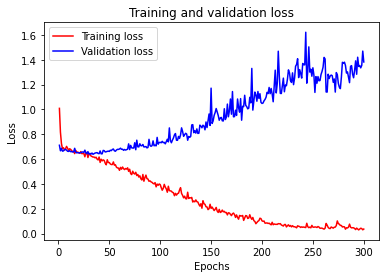

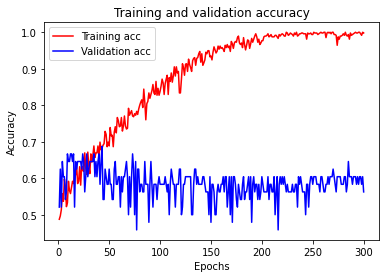

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss = 'sparse_categorical_crossentropy',
              metrics= ['sparse_categorical_accuracy'])
history = model.fit([scalo_train_rescale[:,:,:,i*3:(i+1)*3] for i in range(14)], y_vle_train_label, batch_size=16,epochs=300, steps_per_epoch=491//16, validation_data = ([scalo_val_rescale[:,:,:,i*3:(i+1)*3] for i in range(14)], y_vle_val_label ), validation_steps=61//16)

model.save('parallel_aro_1024.h5')

loss = history.history['loss']
val_loss =history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')      
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

acc = history.history['sparse_categorical_accuracy']           
val_acc = history.history['val_sparse_categorical_accuracy']   

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show() 

